# quartile analysis

histograms of data sets for each month/year combination are fit to a curve. 1st, 2nd, and 3rd quartile data is then computed from this curve.

the aggregate quartile data is output to `csv` files. 

a few plots are generated to examine year-over-year performance.

---

## first, we need to define a few functions

In [26]:
# import relevant modules
import scipy.stats
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [36]:


def get_quartiles(data):
    # generate fit function
    z = scipy.stats.gaussian_kde(data)

    # get a bunch of x data
    x = np.linspace(0,40,1000)
    # fit y coordinates to x data
    y = z(x)

    # normalize y so sum = 1
    y_norm = [i/sum(y) for i in y]

    # compute quartiles
    fit_quartiles = {}
    for lim in [0.25, 0.5, 0.75]:
        r = 0
        idx = 0
        while r + y_norm[idx] < lim:
            r += y_norm[idx]
            idx += 1
        val = x[idx]

        # add to our fit summary data
        fit_quartiles[str(lim)] = val
    
    return fit_quartiles


In [37]:
def flatten_results(my_results):
    flat_results = []
    
    for r in my_results:
        f = {}
        f['month'] = r['month']
        f['year'] = r['year']
        f['quartile_1'] = r['quartiles']['0.25']
        f['quartile_2'] = r['quartiles']['0.5']
        f['quartile_3'] = r['quartiles']['0.75']
        flat_results.append(f)
    return flat_results

In [38]:
def generate_quartile_result_file(in_file_name):
    
    # read in data
    df = pd.read_csv('{i}.csv'.format(i=in_file_name))

    # get distinct year and month values
    years = set(df['year'])
    months = set(df['month'])
    
    # create results dictionary
    results = []

    # iterate through year/month combos and get quartile data
    for year in years:
        for month in months:
            days = list(df[(df['month'] == month) & (df['year'] == year)]['days'])

            if len(days) < 2:
                # no values, break out of loop (oct 2016 for example)
                continue

            quartile_data = get_quartiles(days)
            result = {
                'year': year,
                'month': month,
                'quartiles': quartile_data
            }

            # add this result to total list
            results.append(result)
    
    flat_results = flatten_results(results)
    out_df = pd.DataFrame(flat_results)
    out_df.to_csv('out/{o}_results.csv'.format(o=in_file_name), index=False)
    
    

In [39]:
def plot_fit(data_sets, title, include_histogram=False):
    
    fig = plt.figure()
    for data in data_sets:
    
        # generate fit function
        z = scipy.stats.gaussian_kde(data)

        # get a bunch of x data
        x = np.linspace(0,40,1000)
        # fit y coordinates to x data
        y = z(x)

        # plot curve and histogram to show hope dope the pairing is
        plt.plot(x,y)
        if include_histogram:
            plt.hist([j - 0.5 for j in data], normed=True, bins=(max(data)-min(data)))

    
    axes = plt.gca()
    fig.suptitle(title, fontsize=20)
    axes.set_xlim([0,25])
    plt.show()


# time for some results!

In [40]:
# generate output files!
for x in ['stock','surf']:
    generate_quartile_result_file(x)

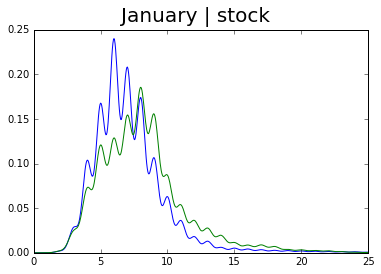

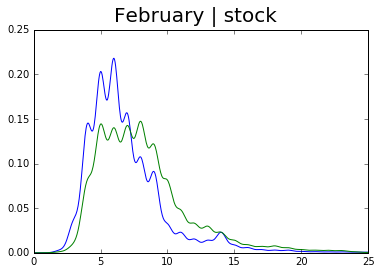

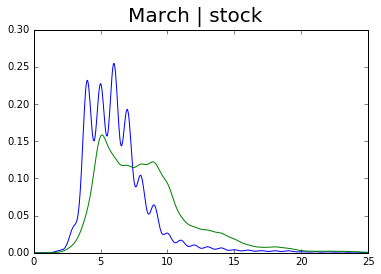

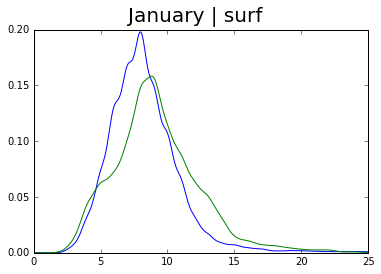

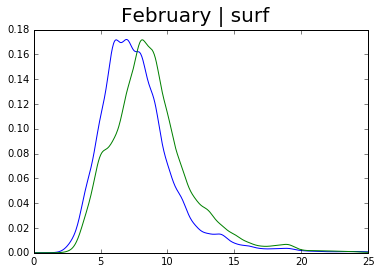

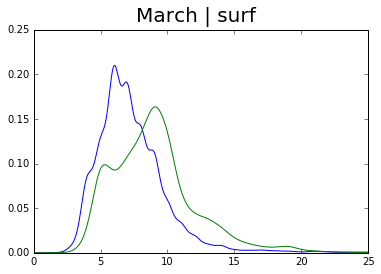

In [45]:
# plot some yoy data for both categories
for x in ['stock','surf']:

    # read in data
    df = pd.read_csv('{i}.csv'.format(i=x))
    
    # generate plots!
    for m in ['January', 'February','March']:
    
        m_df = df[df['month'] == m]

        years_data = []
        for year in set(m_df['year']):
            this_year = list(m_df[m_df['year'] == year]['days'])
            years_data.append(this_year)

        plot_fit(years_data,'{m} | {s}'.format(m=m, s=x))
    